# Long-short strategy

Trades with multiple assets

In [ ]:
import epymetheus

import pandas as pd
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
try:
    import seaborn
    seaborn.set_style('ticks')
except ImportError:
    pass
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from epymetheus import Universe, Trade, TradeStrategy

In [2]:
from epymetheus.datasets import fetch_usstock

universe = fetch_usstock()

In [20]:
from time import sleep

class SimpleLongShort(TradeStrategy):
    """Simple long-short strategy."""
    
    def logic(self, universe, percentile, bet):
        watch_period = DateOffset(months=1)
        trade_period = DateOffset(months=1)
        n_trade = int(universe.n_assets * percentile)

        def trade_open_dates(universe, watch_period, trade_period):
            """Yield begin_date of trades."""
            open_date = universe.bars[0] + watch_period
            while open_date + trade_period <= universe.bars[-1]:
                yield open_date
                open_date += trade_period

        def tot_returns(open_date):
            """Return 1 month return of assets as Series."""
            b = open_date - DateOffset(days=1)
            e = open_date - DateOffset(months=1)
            return universe.prices.loc[e, :] / universe.prices.loc[b, :]

        for open_date in trade_open_dates(universe, watch_period, trade_period):
            close_date = open_date + trade_period
            r = tot_returns(open_date)
            assets_sorted = sorted(universe.assets, key=lambda asset: r[asset])

            for long, short in zip(assets_sorted[-n_trade:], assets_sorted[:n_trade]):
                lot_long = bet / universe.prices.at[open_date, long]
                lot_short = -bet / universe.prices.at[open_date, short]
                yield Trade(
                    asset=[long, short], 
                    lot=[lot_long, lot_short],
                    open_bar=open_date,
                    close_bar=close_date
                )

In [27]:
strategy = SimpleLongShort(percentile=1.0, bet=10000)

In [28]:
strategy.run(universe)

Running ... 
Generating 2380 trades ... Done.
Evaluating history ... Done. (Runtime : 0.19 sec)
Evaluating history ... Done. (Runtime : 14.52 sec)
Evaluating wealth ... Done. (Runtime : 14.80 sec)
Done. (Runtime : 30.2 sec)


In [9]:
history = pd.DataFrame(strategy.history).set_index('order_index')
transaction = pd.DataFrame(strategy.transaction).set_index('bars')
wealth = pd.DataFrame(strategy.wealth).set_index('bars')

In [13]:
history.head()

,trade_index,assets,lots,open_bars,close_bars,durations,open_prices,close_prices,gains
order_index,,,,,,,,,
0,0,JNJ,400.535384,2000-02-01,2000-03-01,29 days,24.966583,21.755880,-1286.000116
1,0,JPM,-323.370362,2000-02-01,2000-03-01,29 days,30.924294,30.278114,208.955202
2,1,BRK-A,0.192678,2000-02-01,2000-03-01,29 days,51900.000000,44700.000000,-1387.283237
3,1,XOM,-430.676288,2000-02-01,2000-03-01,29 days,23.219296,21.469923,753.413247
4,2,AMZN,148.285449,2000-02-01,2000-03-01,29 days,67.437500,65.875000,-231.696015


In [14]:
transaction.head()

,AAPL,MSFT,AMZN,BRK-A,JPM,JNJ,WMT,BAC,PG,XOM
bars,,,,,,,,,,
2000-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
wealth.head()

,wealth
bars,
2000-01-01,0.0
2000-01-02,0.0
2000-01-03,0.0
2000-01-04,0.0
2000-01-05,0.0


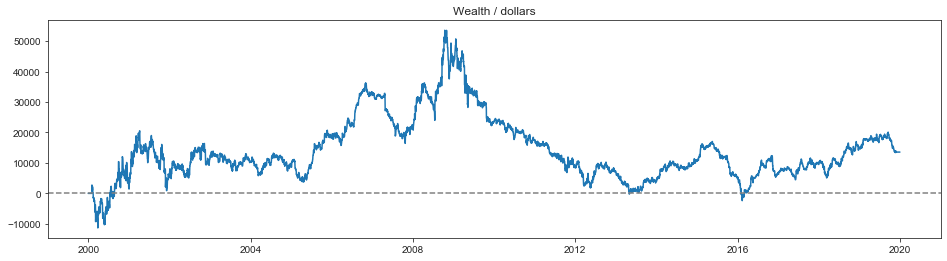

In [17]:
plt.figure(figsize=(16, 4))
plt.plot(wealth)
plt.axhline(0, color='gray', ls='--')
plt.title('Wealth / dollars')
plt.show()

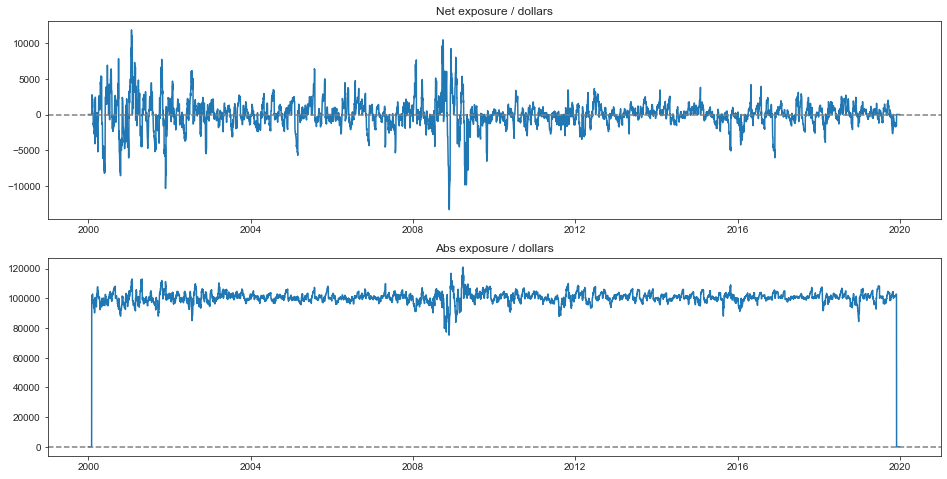

In [18]:
net_exposure = (transaction.cumsum() * universe.prices).sum(axis=1)
abs_exposure = (transaction.cumsum().applymap(abs) * universe.prices).sum(axis=1)

plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(net_exposure)
plt.axhline(0, color='gray', ls='--')
plt.title('Net exposure / dollars')

plt.subplot(2, 1, 2)
plt.plot(abs_exposure)
plt.axhline(0, color='gray', ls='--')
plt.title('Abs exposure / dollars')

plt.show()

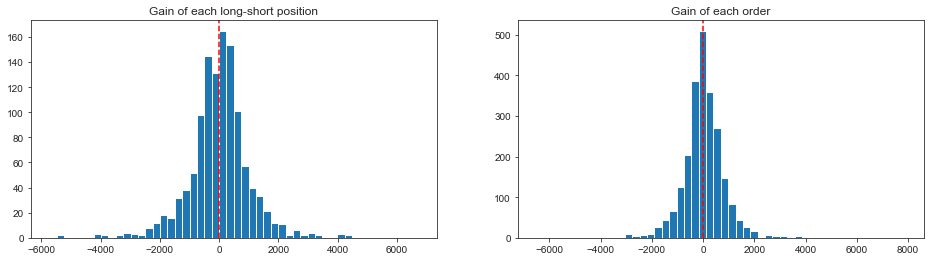

In [19]:
gains = history.gains
gains_agg = history[['trade_index', 'gains']].groupby('trade_index').agg('sum')

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.hist(gains_agg.values, bins=50)
plt.axvline(0, color='red', ls='--')
plt.title('Gain of each long-short position')

plt.subplot(1, 2, 2)
plt.hist(gains, bins=50)
plt.axvline(0, color='red', ls='--')
plt.title('Gain of each order')

plt.show()